In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange

C:\Users\hong guo peng\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# make up data
x_data = np.linspace(-7 , 10 , 2500).reshape([-1 , 1])
np.random.shuffle(x_data)
noise = np.random.normal(0 , 5 , x_data.shape)
y_data = np.square(x_data) - 5 + noise

In [3]:
def dense_layer(inputs , in_size , out_size , activaction_function = None):
    # weights and biases 
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001) , name = 'weight')
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias')

    # fully connected product
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases)
    
    if activaction_function: output = activaction_function(Wx_plus_b)
    else: output = Wx_plus_b
  
    return output

def highway_layer(inputs , in_size , out_size):
    with tf.variable_scope('transform_gate'): 
        # fully connected product for transform
        transform_output = dense_layer(inputs , in_size , out_size , tf.nn.relu)
 
    with tf.variable_scope('copy_gate'):  
        # fully connected product for copy 
        # 用tf.nn.sigmoid讓Wx_plus_b_c的每個元素在0~1的範圍中
        copy_coef = dense_layer(inputs , in_size , out_size , tf.nn.sigmoid)
        
    with tf.variable_scope('output_gate'):
        final_output = tf.multiply(copy_coef , inputs) + tf.multiply(1 - copy_coef , transform_output)
               
    return final_output

In [4]:
class network(object):
    def __init__(self , HIDDEN_UNITS , HIDDEN_LAYER_NUM , LEARNING_RATE , HIGHWAY):
        self.hidden_units = HIDDEN_UNITS
        self.hidden_layer_num = HIDDEN_LAYER_NUM
        self.learning_rate = LEARNING_RATE
        self.xs = tf.placeholder(tf.float32 , [None , 1] , name = 'xs')  # [num_samples , num_features]
        self.ys = tf.placeholder(tf.float32 , [None , 1] , name = 'ys')
        self.highway = HIGHWAY
        
        with tf.variable_scope('bulid_bn_network'):
            self.bulid_network()
        
        with tf.variable_scope('cost'):
            self.compute_cost()
            
        with tf.variable_scope('train'):
            self.train_model()
            
            
    @staticmethod
    def highway_layer(inputs , in_size , out_size):
        with tf.variable_scope('transform_gate'): 
            # fully connected product for transform
            transform_output = dense_layer(inputs , in_size , out_size , tf.nn.relu)

        with tf.variable_scope('copy_gate'):  
            # fully connected product for copy 
            # 用tf.nn.sigmoid讓Wx_plus_b_c的每個元素在0~1的範圍中
            copy_coef = dense_layer(inputs , in_size , out_size , tf.nn.sigmoid)

        with tf.variable_scope('output_gate'):
            final_output = tf.multiply(copy_coef , inputs) + tf.multiply(1 - copy_coef , transform_output)

        return final_output
        
    @staticmethod
    def dense_layer(inputs , in_size , out_size , activaction_function = None):
        # weights and biases 
        Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001) , name = 'weight')
        biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias')

        # fully connected product
        Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases)

        if activaction_function is not None: output = activaction_function(Wx_plus_b)
        else: output = Wx_plus_b

        return output
    
    def bulid_network(self):    
        # record in
        self.input_ = []
        self.input_.append(self.xs)
                   
        # build hidden layers & highway layers
        if self.highway:
            for l_n in range(0 , self.hidden_layer_num):
                with tf.variable_scope('hidden_layer' + str(l_n + 1)): 
                    L_act = self.highway_layer(self.input_[l_n] , 
                                               self.input_[l_n].shape[1].value , 
                                               self.hidden_layer_num)  
                    self.input_.append(L_act) 
                 
        # build hidden layers 
        else: 
            for layer in range(0 , self.hidden_layer_num):
                with tf.variable_scope('layer_' + str(layer + 1)): 
                    L_act = self.dense_layer(self.input_[layer] , 
                                             self.input_[layer].shape[1].value ,
                                             self.hidden_units)
                    self.input_.append(L_act) 
            
         
        # build output layer
        with tf.variable_scope('prediction'):    
            self.prediction = self.dense_layer(self.input_[-1] , 
                                               self.input_[-1].shape[1].value , 1)
    def compute_cost(self):    
        self.cost = tf.reduce_mean(tf.reduce_sum(tf.square(self.ys - self.prediction) , reduction_indices = [1]) , name = 'cost')
    
    def train_model(self):
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)

In [5]:
with_HN = network(HIDDEN_UNITS = 30 , 
                  HIDDEN_LAYER_NUM = 40 , 
                  LEARNING_RATE = 0.0001 , 
                  HIGHWAY = True)

without_HN = network(HIDDEN_UNITS = 30 , 
                     HIDDEN_LAYER_NUM = 40 , 
                     LEARNING_RATE = 0.0001 , 
                     HIGHWAY = False)

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
   
def minibatch_index(minibatch_num , data):
    step = (int(len(data) / minibatch_num) + 1) * minibatch_num
    temp = []
    index = []
    j = 0
    for ii in range(0 , step):
        j = j + 1
        if j > len(data):
            j = j - (len(data))   
        temp.append(j)  
        if len(temp) == minibatch_num:
            index.append(temp)
            temp = []
    index = list(np.array(index) - 1) 
    return index
index = minibatch_index(minibatch_num = 100 , data = x_data)         

In [7]:
cost_his_with_HN = []
cost_his_without_HN = []
epochs = 100
for epoch in trange(0 , epochs):
    for i in range(0 , len(index)):
        # train on batch
        sess.run(with_HN.train_op , feed_dict = {with_HN.xs : x_data[index[i]] , with_HN.ys : y_data[index[i]]})  
        sess.run(without_HN.train_op , feed_dict = {without_HN.xs : x_data[index[i]] , without_HN.ys : y_data[index[i]]})           
        
    # record cost
    cost_his_with_HN.append(sess.run(with_HN.cost , feed_dict = {with_HN.xs : x_data , with_HN.ys : y_data}))    
    cost_his_without_HN.append(sess.run(without_HN.cost , feed_dict = {without_HN.xs : x_data , without_HN.ys : y_data}))    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.88it/s]


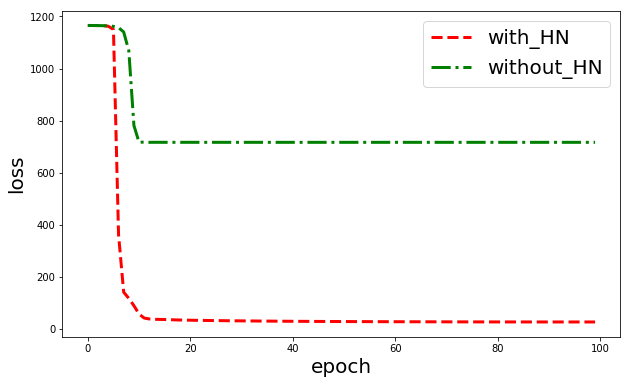

In [8]:
# plot cost curve
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.plot(np.arange(len(cost_his_with_HN)) , np.array(cost_his_with_HN) , ls = '--' , linewidth = 3 , c = 'r' , label = 'with_HN')     
ax.plot(np.arange(len(cost_his_without_HN)) , np.array(cost_his_without_HN) , ls = '-.' , linewidth = 3 , c = 'g' , label = 'without_HN')     
ax.set_xlabel('epoch' , fontsize = 20)
ax.set_ylabel('loss' , fontsize = 20)
ax.legend(fontsize = 20)

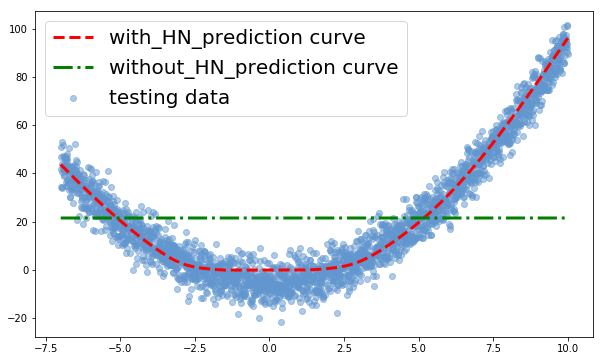

In [9]:
# plot prediction curve
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
x_test = np.linspace(-7 , 10 , 2500).reshape([-1 , 1])
y_test = np.square(x_test) - 5 + np.random.normal(0 , 5 , x_data.shape)
ax.scatter(x_test , y_test , c = '#6196cf' , alpha = 0.5 , label = 'testing data')

pred_with_HN = sess.run(with_HN.prediction , feed_dict = {with_HN.xs : x_test , with_HN.ys : y_test})
pred_without_HN = sess.run(without_HN.prediction , feed_dict = {without_HN.xs : x_test , without_HN.ys : y_test})

ax.plot(x_test , pred_with_HN , ls = '--' , linewidth = 3 , c = 'r' , label = 'with_HN_prediction curve')
ax.plot(x_test , pred_without_HN , ls = '-.' , linewidth = 3 , c = 'g' , label = 'without_HN_prediction curve')
ax.legend(fontsize = 20)